# Crop Disease Classification Assessment
### Aryan SIngh Rawat
### rawat.aryanx@gmail.com 

# Importing Librarires

In [60]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
import splitfolders
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras.utils import load_img, img_to_array

import warnings
warnings.filterwarnings('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Defing paths for dataset, image size, batch size and other parameters for easy configuration and consistency throughout the training process

In [61]:
IMAGES_FOLDERS_PATH = 'data/PlantVillage'
OUTPUT_FOLDER = 'plantdisease_split'
BATCH_SIZE = 64
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
EPOCHS = 100

# Data Exploration

Showing 5 disease classes (excluding 'healthy'):

 - Tomato_Spider_mites_Two_spotted_spider_mite
 - Tomato_Bacterial_spot
 - Pepper__bell___Bacterial_spot
 - Potato___Early_blight
 - Tomato__Tomato_YellowLeaf__Curl_Virus


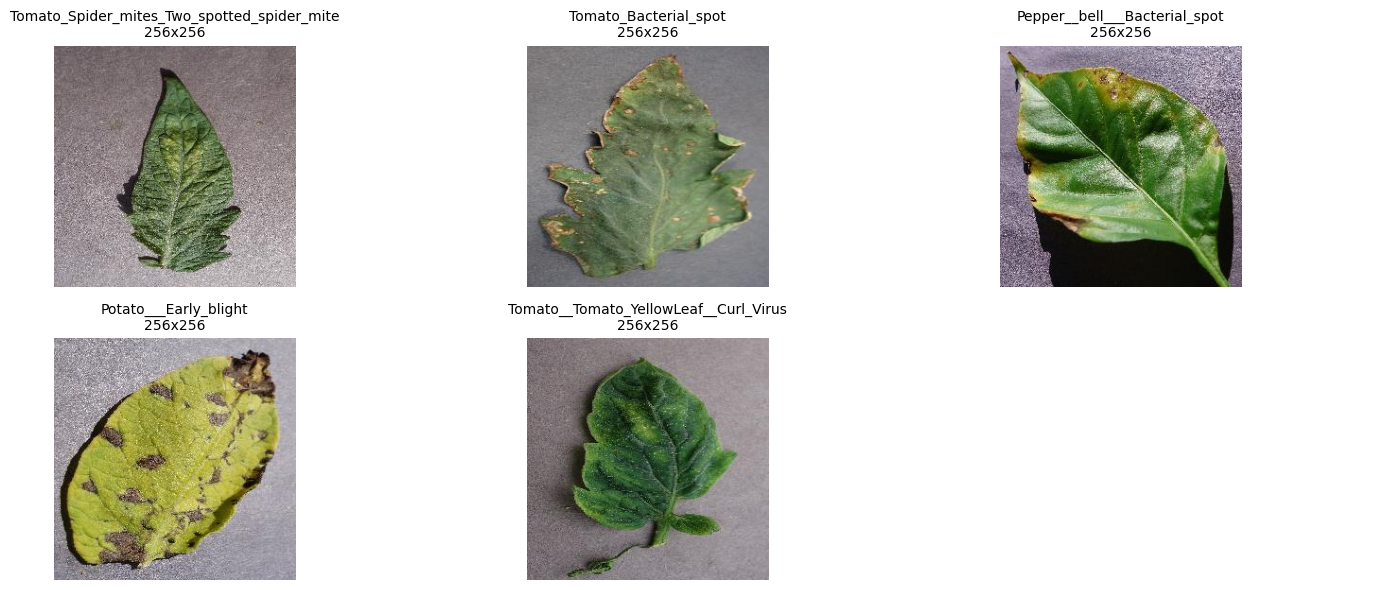

In [62]:
def VisualizeDiseaseClasses(folders_path, num_classes=5):
    """
    Visualize sample images from disease classes (exclude 'healthy' ones).
    Automatically skips empty folders.
    """
    all_classes = os.listdir(folders_path)

    # Filter disease classes (exclude 'healthy')
    disease_classes = [c for c in all_classes if "healthy" not in c.lower()]

    # Remove classes with no images
    valid_classes = []
    for c in disease_classes:
        class_path = os.path.join(folders_path, c)
        if os.path.isdir(class_path) and len(os.listdir(class_path)) > 0:
            valid_classes.append(c)

    # Randomly select up to num_classes
    selected_classes = random.sample(valid_classes, min(num_classes, len(valid_classes)))

    print(f"Showing {len(selected_classes)} disease classes (excluding 'healthy'):\n")
    for c in selected_classes:
        print(f" - {c}")

    # Set up grid
    cols = 3
    rows = (len(selected_classes) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()

    # Show one image per class
    for i, cls in enumerate(selected_classes):
        class_path = os.path.join(folders_path, cls)
        img_files = os.listdir(class_path)
        if len(img_files) == 0:
            continue
        img_path = os.path.join(class_path, img_files[0])
        image = mpimg.imread(img_path)
        with Image.open(img_path) as img:
            width, height = img.size
        axes[i].imshow(image)
        axes[i].set_title(f"{cls}\n{width}x{height}", fontsize=10)
        axes[i].axis("off")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


VisualizeDiseaseClasses(IMAGES_FOLDERS_PATH, num_classes=5)

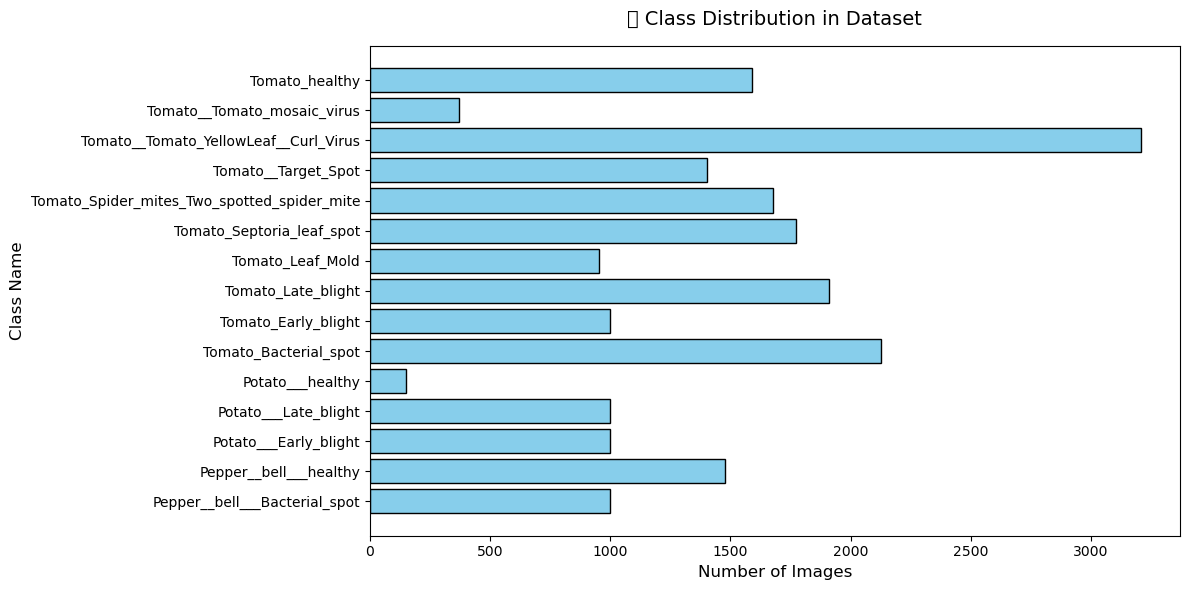

✅ Total classes: 15
🖼️ Total images: 20639

Top 5 classes by image count:
 - Tomato__Tomato_YellowLeaf__Curl_Virus: 3209 images
 - Tomato_Bacterial_spot: 2127 images
 - Tomato_Late_blight: 1909 images
 - Tomato_Septoria_leaf_spot: 1771 images
 - Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images


In [63]:
def plot_class_distribution(folders_path):
    """
    Plots a bar chart showing the number of images in each class folder.
    Works for both healthy and disease classes.
    """
    class_counts = {}

    # Loop through all class folders
    for class_name in sorted(os.listdir(folders_path)):
        class_path = os.path.join(folders_path, class_name)
        if os.path.isdir(class_path):
            count = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ])
            class_counts[class_name] = count

    # Plot bar chart
    plt.figure(figsize=(12, 6))
    plt.barh(list(class_counts.keys()), list(class_counts.values()), color="skyblue", edgecolor="black")
    plt.xlabel("Number of Images", fontsize=12)
    plt.ylabel("Class Name", fontsize=12)
    plt.title("📊 Class Distribution in Dataset", fontsize=14, pad=15)
    plt.tight_layout()
    plt.show()

    # Print summary
    total_images = sum(class_counts.values())
    print(f"✅ Total classes: {len(class_counts)}")
    print(f"🖼️ Total images: {total_images}")
    print("\nTop 5 classes by image count:")
    for name, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f" - {name}: {count} images")

plot_class_distribution(IMAGES_FOLDERS_PATH)


From the above bar chart, we can observe that the dataset is imbalanced across different plant disease classes. Some classes, such as Tomato_Tomato_YellowLeaf_Curl_Virus, have a significantly higher number of samples (over 3000 images), whereas others like Potato___healthy and Tomato__Tomato_mosaic_virus have far fewer examples.
This imbalance indicates that the model might become biased toward majority classes, performing well on frequently occurring diseases but struggling to correctly identify less-represented ones.
To address this, techniques such as data augmentation, class weighting, or oversampling/undersampling could be applied during training.
Overall, the visualization provides a useful overview of dataset diversity and highlights the need for balancing strategies before training the model.

# Data preparation

In [64]:
# Split the dataset into training (80%) and validation (20%) folders
splitfolders.ratio(IMAGES_FOLDERS_PATH, output=OUTPUT_FOLDER, seed=42, ratio=(0.8, 0.2))

Copying files: 20639 files [00:08, 2478.08 files/s]


In [65]:
# Define the training and validation dataset paths
TRAIN_FOLDER_PATH = 'plantdisease_split/train'
VAL_FOLDER_PATH = 'plantdisease_split/val'

# Data augmentation for training images (adds variations to improve generalization)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Apply MobileNetV3 preprocessing
    rotation_range=20, # Random rotations
    width_shift_range=0.2, # Horizontal shifts
    height_shift_range=0.2, # Vertical shifts
    shear_range=0.2, # Shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest' # Fill missing pixels after transformations
)
train_image_generator = train_datagen.flow_from_directory(
                                            TRAIN_FOLDER_PATH,
                                            target_size=(WIDTH, HEIGHT), # Resize all images to 224x224
                                            batch_size= BATCH_SIZE, # Number of images per batch
                                            class_mode='categorical') # Multi-class classification


# Validation images (no augmentation, only preprocessing)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_image_generator = val_datagen.flow_from_directory(
                                            VAL_FOLDER_PATH,
                                            target_size=(WIDTH, HEIGHT),
                                            batch_size= BATCH_SIZE,
                                            class_mode='categorical')

Found 16504 images belonging to 15 classes.
Found 4134 images belonging to 15 classes.


In [66]:
class_names = list(val_image_generator.class_indices.keys()) 
class_names


['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

# Model Training

In [67]:
# Load the MobileNetV3-Large model pre-trained on ImageNet (without the top classification layer)
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, CHANNELS))

# Freeze the base model layers to keep pretrained weights during initial training
base_model.trainable = False

# Build the new model on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(train_image_generator.num_classes,activation='softmax')) #Output layer for classification

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_4  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 512)               492032    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)              

In [68]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,              # Stop if no improvement for 5 epochs
    restore_best_weights=True # Restore the model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(
    train_image_generator,
    epochs = EPOCHS,
    verbose = 1,
    callbacks = early_stopping,
    validation_data = val_image_generator
)


Epoch 1/100
258/258 [==============================] - 126s 483ms/step - loss: 1.5565 - accuracy: 0.5190 - val_loss: 0.7250 - val_accuracy: 0.7891
Epoch 2/100
258/258 [==============================] - 138s 534ms/step - loss: 0.7353 - accuracy: 0.7655 - val_loss: 0.4506 - val_accuracy: 0.8636
Epoch 3/100
258/258 [==============================] - 170s 657ms/step - loss: 0.5312 - accuracy: 0.8270 - val_loss: 0.3546 - val_accuracy: 0.8948
Epoch 4/100
258/258 [==============================] - 169s 655ms/step - loss: 0.4382 - accuracy: 0.8573 - val_loss: 0.2930 - val_accuracy: 0.9141
Epoch 5/100
258/258 [==============================] - 172s 665ms/step - loss: 0.3728 - accuracy: 0.8814 - val_loss: 0.2622 - val_accuracy: 0.9178
Epoch 6/100
258/258 [==============================] - 170s 657ms/step - loss: 0.3325 - accuracy: 0.8920 - val_loss: 0.2224 - val_accuracy: 0.9286
Epoch 7/100
258/258 [==============================] - 174s 674ms/step - loss: 0.2964 - accuracy: 0.9036 - val_loss: 0

In [69]:
# Unfreeze the last 30 layers of the base model to fine-tune higher-level features
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),  
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train (fine-tune) the model again on the training data
fine_tune_history = model.fit(
    train_image_generator,
    validation_data=val_image_generator,
    epochs=EPOCHS,
    callbacks = early_stopping,
    verbose=1
)

Epoch 1/100
258/258 [==============================] - 159s 610ms/step - loss: 0.6609 - accuracy: 0.8160 - val_loss: 0.1862 - val_accuracy: 0.9405
Epoch 2/100
258/258 [==============================] - 151s 585ms/step - loss: 0.2814 - accuracy: 0.9066 - val_loss: 0.1948 - val_accuracy: 0.9371
Epoch 3/100
258/258 [==============================] - 150s 581ms/step - loss: 0.2420 - accuracy: 0.9175 - val_loss: 0.1716 - val_accuracy: 0.9446
Epoch 4/100
258/258 [==============================] - 154s 597ms/step - loss: 0.2131 - accuracy: 0.9286 - val_loss: 0.1509 - val_accuracy: 0.9490
Epoch 5/100
258/258 [==============================] - 145s 560ms/step - loss: 0.2039 - accuracy: 0.9325 - val_loss: 0.1404 - val_accuracy: 0.9523
Epoch 6/100
258/258 [==============================] - 137s 530ms/step - loss: 0.1928 - accuracy: 0.9351 - val_loss: 0.1322 - val_accuracy: 0.9531
Epoch 7/100
258/258 [==============================] - 147s 569ms/step - loss: 0.1699 - accuracy: 0.9420 - val_loss: 0

In [70]:
model.save('plant_disease_classifier.h5')
print("Model saved as 'plant_disease_classifier.h5'")

Model saved as 'plant_disease_classifier.h5'


# Model Evaluation and Confusion Matrix

In [71]:
model= load_model("plant_disease_classifier.h5")
loss, accuracy = model.evaluate(val_image_generator, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


65/65 [==============================] - 27s 402ms/step - loss: 0.1307 - accuracy: 0.9548
Test Accuracy: 95.48%
Test Loss: 0.1307


In [72]:
val_image_generator.shuffle = False
pred= model.predict(val_image_generator)

65/65 [==============================] - 27s 408ms/step


<Figure size 1200x500 with 0 Axes>

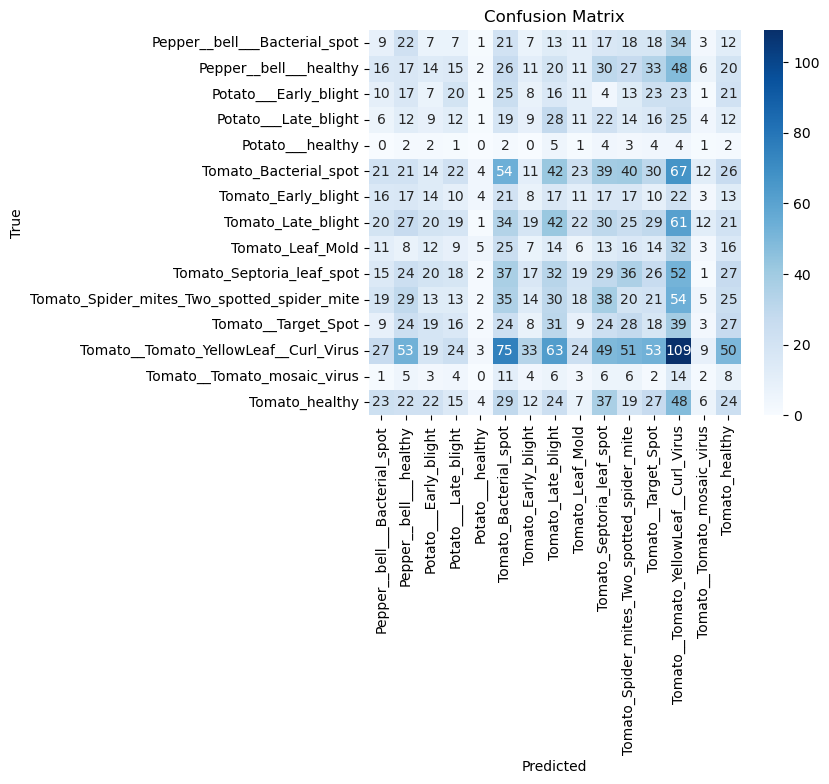

In [73]:
true_labels = val_image_generator.classes

pred_classes = np.argmax(pred, axis=1)

cm= confusion_matrix(true_labels, pred_classes)

plt.figure(figsize=(12, 5))

# ---------- FIGURE 1 (Before) ----------
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


✅ Found 357 correct and 3777 incorrect predictions


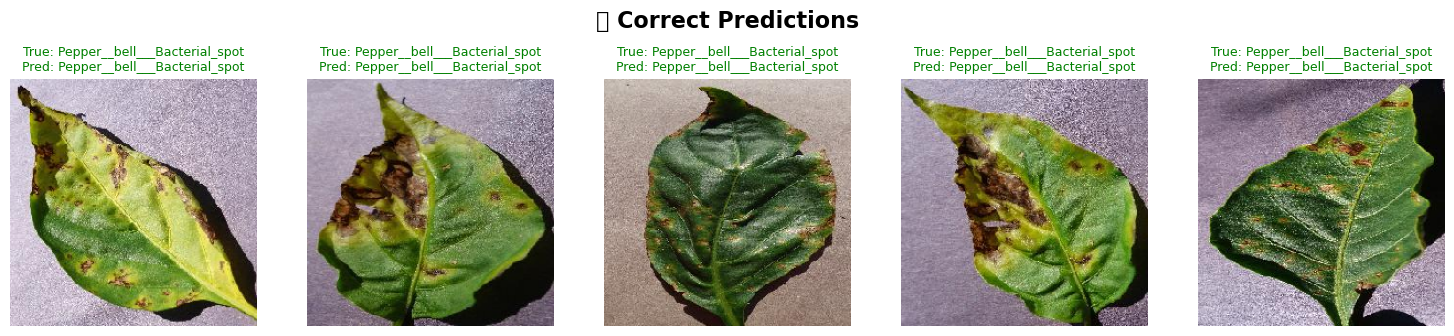

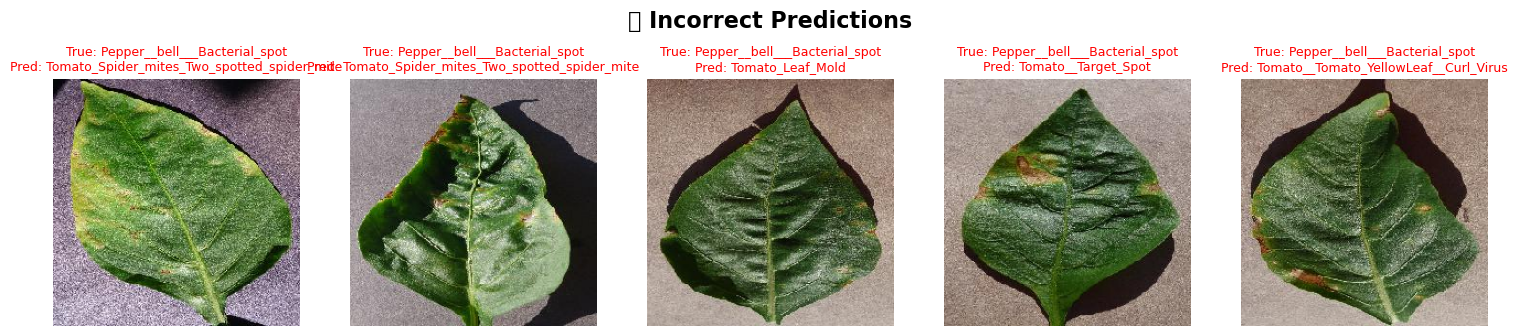

In [74]:
# Identify correct and incorrect predictions
correct_indices = np.where(pred_classes == true_labels)[0]
incorrect_indices = np.where(pred_classes != true_labels)[0]

print(f"✅ Found {len(correct_indices)} correct and {len(incorrect_indices)} incorrect predictions")

# Select 5 of each
num_samples = 5
correct_indices = correct_indices[:num_samples]
incorrect_indices = incorrect_indices[:num_samples]

# Get file paths from the validation generator
file_paths = np.array(val_image_generator.filepaths)

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to visualize predictions
def plot_predictions(indices, title, correct=True):
    plt.figure(figsize=(15, 6))
    plt.suptitle(title, fontsize=16, fontweight='bold')
    
    for i, idx in enumerate(indices):
        img_path = file_paths[idx]
        img = image.load_img(img_path, target_size=(224, 224))
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        
        true_label = class_names[true_labels[idx]]
        pred_label = class_names[pred_classes[idx]]
        color = "green" if correct else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=9)
    
    plt.tight_layout()
    plt.show()

# ✅ Plot 5 correct predictions
plot_predictions(correct_indices, "✅ Correct Predictions", correct=True)

# ❌ Plot 5 incorrect predictions
plot_predictions(incorrect_indices, "❌ Incorrect Predictions", correct=False)


# Bussiness Recommendation

1.For mobile app deployment for farmers, we need a model which is lightweight,fast and can run in offline mode on mid-range phones.

2.MobileNetV3-large is astrong choice as it offers a good balance of accuracy, model size and inference speed, making it suitable for real-time crop disease deteection on mobile devices.

3.Considering some heavier models like EfficientNet-B3/B5 or Resnet18/50 can provide a slightly better accuracy, but are slower and consume more memory,making them less suitable for low end devices.

4.For extremely lightweight model like MobileNetV2 or EfficientNet-Lite0 are smaller and faster but tend to lose classification accuracy, which may impact disease diagnosis reliability.

5.For mobile deployment we can use Tensorflowlite or TFLite conversion which allows to run fully offline availability of the model enabling the farmers to use the application without even needing a network connectivity.
